data/data.csv
有重複資料
562 => 522

In [1]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import f1_score

In [31]:
df = pd.read_csv("data/linear_features/cdhit80_k4_linear10_loc75.csv")

In [32]:
df["loc"].value_counts()

Cytosolic    2811
Nucleus       229
Name: loc, dtype: int64

[1973 1811 1444 ...  858  162  418]
2432
608
Cytosolic    2245
Nucleus       187
Name: loc, dtype: int64
Cytosolic    566
Nucleus       42
Name: loc, dtype: int64


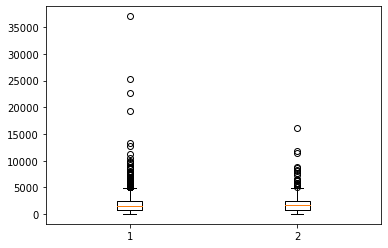

In [23]:
idx = np.arange(len(df))
np.random.shuffle(idx)
print(idx)
train_df = df[df.index.isin(idx[:int(len(idx) * 0.8)])]
print(len(train_df))
test_df = df[df.index.isin(idx[int(len(idx) * 0.8):])]
print(len(test_df))
print(train_df["loc"].value_counts())
print(test_df["loc"].value_counts())
len_box = [train_df['len'], test_df['len']]
plt.boxplot(len_box)
plt.show()

In [24]:
train_df.to_csv("data/linear_features/cdhit80_k4_linear10_loc75_train.csv", index=False)
test_df.to_csv("data/linear_features/cdhit80_k4_linear10_loc75_test.csv", index=False)

In [149]:
k = 2
data_df = pd.read_csv("data/linear_features/cdhit80_k" + str(k) + "_linear10_loc75_train.csv")
vocab = np.load("data/linear_features/cdhit80_k" + str(k) + "_vocab.npy")

In [150]:
col = data_df.columns
data_x = data_df[col[:-2]].to_numpy()
data_y = data_df[col[-1]].to_numpy()
data_y = np.where(data_y == "Cytosolic", 1, 0)

idx = np.arange(len(data_y))
np.random.shuffle(idx)
x_train = data_x[idx[:int(len(idx) * 0.8)]]
y_train = data_y[idx[:int(len(idx) * 0.8)]]
x_test = data_x[idx[int(len(idx) * 0.8):]]
y_test = data_y[idx[int(len(idx) * 0.8):]]
print(x_train.shape)
y_weight = np.unique(y_train, return_counts=True)[1]
print(y_weight)
print(x_test.shape)
print(np.unique(y_test, return_counts=True))

(1945, 176)
[ 142 1803]
(487, 176)
(array([0, 1]), array([ 31, 456]))


In [66]:
prob = svm_problem(y_train, x_train, isKernel=True)
param = svm_parameter('-t 1 -c 4 -w0 ' + str(y_weight[1]) + ' -w1 ' + str(y_weight[0]))
m = svm_train(prob, param)
p_label, p_acc, p_val = svm_predict(y_test, x_test, m)

Accuracy = 7.18686% (35/487) (classification)


In [37]:
preformance_vacab = []

for i in range(len(vocab)):
    # prob = svm_problem(y_train, x_train[:, 11*i:11*i+11], isKernel=True)
    # param = svm_parameter('-t 1 -c 10 -w0 ' + str(y_weight[1]) + ' -w1 ' + str(y_weight[0]))
    # m = svm_train(prob, param)
    # p_label, p_acc, p_val = svm_predict(y_test, x_test[:, 11*i:11*i+11], m)
    # f1 = f1_score(y_test, p_label, average=None)
    # print(f1)
    clf = svm.SVC(kernel='rbf', C=1, class_weight='balanced').fit(x_train[:, 11*i:11*i+11], y_train)
    y_pred = clf.predict(x_test[:, 11*i:11*i+11])
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average=None)
    preformance_vacab.append([i, f1_macro, f1[0], f1[1]])
    # print("score:", clf.score(x_test[:, 11*i:11*i+11], y_test))
preformance_vacab = np.array(preformance_vacab)
preformance_vacab = preformance_vacab[np.argsort(preformance_vacab[:, 1])]

In [38]:
preformance_vacab[-5:]

array([[2.17000000e+02, 5.00904268e-01, 1.20689655e-01, 8.81118881e-01],
       [2.12000000e+02, 5.15576049e-01, 1.57480315e-01, 8.73671783e-01],
       [5.90000000e+01, 5.20848951e-01, 8.69565217e-02, 9.54741379e-01],
       [2.39000000e+02, 5.23483366e-01, 1.42857143e-01, 9.04109589e-01],
       [2.04000000e+02, 5.23483366e-01, 1.42857143e-01, 9.04109589e-01]])

In [5]:
clf = svm.SVC(kernel='rbf', C=1, class_weight='balanced').fit(x_train, y_train)

print("score:", clf.score(x_test, y_test))

# clf = svm.SVC(kernel='linear', C=1, class_weight='balanced')
# scores = cross_val_score(clf, x_train, y_train, cv=10)
# print(scores)

vild_nuc = y_test == 0
vild_cyt = y_test == 1
score_nuc = clf.score(x_test[vild_nuc], y_test[vild_nuc])
score_cyt = clf.score(x_test[vild_cyt], y_test[vild_cyt])
print("Nucleus:", score_nuc)
print("Cytosolic:", score_cyt)

score: 0.7063655030800822
Nucleus: 0.34146341463414637
Cytosolic: 0.7399103139013453


In [22]:
value_counts = train_df["loc"].value_counts()

for i in range(len(value_counts)):
    while (max(value_counts) - value_counts[i]) / max(value_counts) > .1:
        print((max(value_counts) - value_counts[i]) / max(value_counts))
        train_df = train_df.append(train_df[train_df["loc"] == value_counts.index[i]][:(max(value_counts) - value_counts[i])])
        value_counts = train_df["loc"].value_counts()

print(value_counts)


0.9194444444444444
0.8388888888888889
0.6777777777777778
0.35555555555555557
Cytosolic    1800
Nucleus      1800
Name: loc, dtype: int64


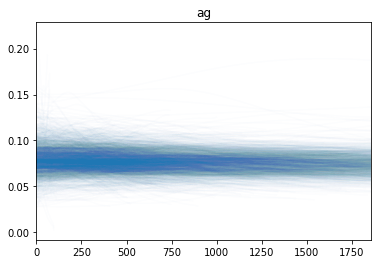

In [33]:
col = data_df.columns
cyt_df = data_df[data_df["loc"] == "Cytosolic"]
cyt_l = cyt_df.loc[:, ["len"]].to_numpy()

len_v = int((len(col)-2) / 11)

for i in range(len_v):
    for z, l in zip(cyt_df.loc[:, col[11*i:11*i+11]].to_numpy(), cyt_l):
        t = np.arange(0, l, 0.01)
        p = np.poly1d(z)

        plt.plot(t, p(t), alpha=0.01, color="#1f77b4")
    plt.xlim(0, np.average(cyt_l))
    plt.title(vocab[i])
    plt.show()
    break

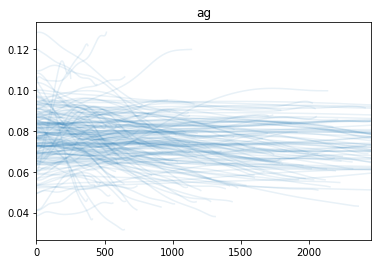

In [32]:
nuc_df = data_df[data_df["loc"] == "Nucleus"]
nuc_l = nuc_df.loc[:, ["len"]].to_numpy()
len_v = int((len(col)-2) / 11)

for i in range(len_v):
    for z, l in zip(nuc_df.loc[:, col[11*i:11*i+11]].to_numpy(), nuc_l):
        t = np.arange(0, l, 0.01)
        p = np.poly1d(z)

        plt.plot(t, p(t), alpha=0.1, color="#1f77b4")
    plt.xlim(0, np.average(nuc_l))
    plt.title(vocab[i])
    plt.show()
    break

In [106]:
class NN2Layers(torch.nn.Module):
    def __init__(self, ninp: int, nhid: int, ntoken: int, dropout: float=0.0):
        
        super(NN2Layers, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.nn1 = nn.Linear(ninp, nhid)
        self.nn2 = nn.Linear(nhid, ntoken)

        self.init_weights()

        self.ninp = ninp
        self.nhid = nhid
        self.ntoken = ntoken

    def init_weights(self):
        initrange = 0.1
        self.nn1.bias.data.zero_()
        self.nn1.weight.data.uniform_(-initrange, initrange)
        self.nn2.bias.data.zero_()
        self.nn2.weight.data.uniform_(-initrange, initrange)

    def forward(self, x: torch.tensor):

        output = self.nn1(x)
        output = self.drop(output)
        output = self.nn2(output)

        return output.softmax(dim=1)
 
    def predict(self, x: torch.tensor):
        # """預測並輸出機率大的類別

        # Args:
        #     x (torch.tensor): 詞 tensor。如果batch_first=True，input shape為（批次，序列），否則（序列，批次）。

        # Returns:
        #     [torch.tensor]: shape 與 x 一樣，但是序列為類別序列。
        # """
        output = self.forward(x)
        _, output = torch.max(output, 1)

        return output

In [151]:
x = x_train
y = y_train
# y = np.where(y == "Cytosolic" , 1, 0)

unique, counts = np.unique(y, return_counts=True)

y_weight = np.unique(y, return_counts=True)[1] / len(y)
y_weight = np.abs(y_weight - 1)
print(y_weight)

[0.92699229 0.07300771]


In [210]:
ntoken = 2

ninp = x_train.shape[1]
nhid = 512

model = NN2Layers(ninp, nhid, ntoken)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(y_weight).to(torch.float))
# optimizer = optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=3e-1)

batch_size = 8
epochs = 500

tensor_x = torch.tensor(x_train).to(torch.float)
tensor_y = torch.tensor(y_train).to(torch.long)

test_x = torch.tensor(x_test).to(torch.float)
test_y = torch.tensor(y_test).to(torch.long)

# dataset = Data.TensorDataset(tensor_x, tensor_y)

# # train_set, valid_set = Data.random_split(dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)], generator=torch.Generator().manual_seed(42))

# loader = Data.DataLoader(
#     dataset = dataset,
#     batch_size = batch_size,
# )

In [195]:
class Trainer():
    def __init__(self, model, optimizer, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
    
    def train(self, x, y, epochs = 2, batch_size = 1, epoch_print = True):
        train_dataset = Data.TensorDataset(x, y)
        loader = Data.DataLoader(
            dataset = train_dataset,
            batch_size = batch_size,
        )
        
        start_time = time.time()
        step_size = len(loader)
        for epoch in range(epochs):
            for step, (batch_x, batch_y) in enumerate(loader):
                step_time = time.time()
                
                self.optimizer.zero_grad()
                pred_y = self.model(batch_x)
                loss = self.loss_fn(pred_y, batch_y)
                loss.backward()
                self.optimizer.step()
                
                # print('Epoch: %i | Step: %i/%i | Loss: %.2f | time: %.2f s' % (epoch, step, step_size, loss, time.time() - step_time))
            if epoch_print:
                print('Epoch: %i | Loss: %.2f | time: %.2f s' % (epoch, loss, time.time() - step_time))
        print('All Time: %.2f s | Loss: %.2f' % (time.time() - start_time, loss))
    
    def test(self, x, y):
        y_pred = self.model.predict(x)
        
        one_hot_y = np.eye(self.model.ntoken)[y]
        one_hot_y_pred = np.eye(self.model.ntoken)[y_pred]
        token_acc_array = []
        for i in range(self.model.ntoken):
            y_token = torch.tensor(one_hot_y[:, i])
            y_pred_token = torch.tensor(one_hot_y_pred[:, i])
            
            tp = (y_token * y_pred_token).sum(dim=0).to(torch.float32)
            tn = ((1 - y_token) * (1 - y_pred_token)).sum(dim=0).to(torch.float32)
            fp = ((1 - y_token) * y_pred_token).sum(dim=0).to(torch.float32)
            fn = (y_token * (1 - y_pred_token)).sum(dim=0).to(torch.float32)
            precision = tp / (tp + fp)
            rec = tp / (tp + fn)
            f1 = 2 * rec * precision / (rec + precision)
            token_acc_array.append(f1)
        acc = (y_pred == y).float().sum() / len(y)
        token_acc_array = torch.tensor(token_acc_array)
        return acc, token_acc_array

In [ ]:
trainer = Trainer(model, optimizer, loss_fn)
trainer.train(tensor_x, tensor_y, epochs, batch_size, epoch_print=False)
trainer.test(test_x, test_y)

In [211]:
preformance_vacab = []
for i in range(len(vocab)):
    model = NN2Layers(11, nhid, ntoken)
    trainer = Trainer(model, optimizer, loss_fn)
    trainer.train(tensor_x[:, 11*i:11*i+11], tensor_y, epochs, batch_size, epoch_print=False)
    acc, token_acc_array = trainer.test(test_x[:10, 11*i:11*i+11], test_y[:10])
    
    preformance_vacab.append(np.append(np.array([i, acc, torch.min(token_acc_array)]), token_acc_array))
preformance_vacab = np.array(preformance_vacab)
preformance_vacab = preformance_vacab[np.argsort(preformance_vacab[:, 2])]

All Time: 43.67 s | Loss: 0.69
All Time: 42.74 s | Loss: 0.69
All Time: 43.57 s | Loss: 0.69
All Time: 44.38 s | Loss: 0.69
All Time: 44.36 s | Loss: 0.69
All Time: 43.77 s | Loss: 0.69
All Time: 43.93 s | Loss: 0.69
All Time: 43.48 s | Loss: 0.69
All Time: 43.79 s | Loss: 0.69
All Time: 44.10 s | Loss: 0.69
All Time: 43.94 s | Loss: 0.70
All Time: 43.93 s | Loss: 0.69
All Time: 43.86 s | Loss: 0.69
All Time: 44.28 s | Loss: 0.69
All Time: 44.88 s | Loss: 0.69
All Time: 45.26 s | Loss: 0.69


In [212]:
preformance_vacab

array([[ 0.        ,  0.1       ,         nan,  0.18181819,         nan],
       [ 1.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 2.        ,  0.1       ,         nan,  0.18181819,         nan],
       [ 3.        ,  0.1       ,         nan,  0.18181819,         nan],
       [ 4.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 5.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 6.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 7.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 8.        ,  0.89999998,         nan,         nan,  0.94736838],
       [ 9.        ,  0.89999998,         nan,         nan,  0.94736838],
       [10.        ,  0.1       ,         nan,  0.18181819,         nan],
       [11.        ,  0.89999998,         nan,         nan,  0.94736838],
       [12.        ,  0.1       ,         nan,  0.18181819,         nan],
       [13.        ,  0.89999998,     

In [52]:
start_time = time.time()
step_size = len(loader)
for epoch in range(epochs):
    correct = 0
    for step, (batch_x, batch_y) in enumerate(loader):
        step_time = time.time()
        model.zero_grad()
        pred = model(batch_x)
        loss = loss_fn(pred, batch_y)
        # print('Epoch: %i | Step: %i/%i | Loss: %.2f | time: %.2f s' % (epoch, step, step_size, loss, time.time() - step_time))
        loss.backward()
        optimizer.step()
        
        correct += (torch.argmax(pred, dim=1) == batch_y).float().sum()

    accuracy = 100 * correct / len(loader.dataset)
    print('Epoch: %i | Loss: %.2f | Accuracy: %.2f | time: %.2f s' % (epoch, loss, accuracy, time.time() - step_time))

print('all time : ', time.time() - start_time,'s')

Epoch: 0 | Loss: 0.67 | Accuracy: 91.57 | time: 0.01 s
Epoch: 1 | Loss: 0.65 | Accuracy: 92.19 | time: 0.00 s
Epoch: 2 | Loss: 0.62 | Accuracy: 92.19 | time: 0.00 s
Epoch: 3 | Loss: 0.59 | Accuracy: 92.19 | time: 0.00 s
Epoch: 4 | Loss: 0.56 | Accuracy: 92.19 | time: 0.00 s
Epoch: 5 | Loss: 0.52 | Accuracy: 92.19 | time: 0.00 s
Epoch: 6 | Loss: 0.49 | Accuracy: 92.19 | time: 0.00 s
Epoch: 7 | Loss: 0.46 | Accuracy: 92.19 | time: 0.00 s
Epoch: 8 | Loss: 0.44 | Accuracy: 92.19 | time: 0.00 s
Epoch: 9 | Loss: 0.42 | Accuracy: 92.19 | time: 0.00 s
Epoch: 10 | Loss: 0.40 | Accuracy: 92.19 | time: 0.00 s
Epoch: 11 | Loss: 0.39 | Accuracy: 92.19 | time: 0.00 s
Epoch: 12 | Loss: 0.38 | Accuracy: 92.19 | time: 0.00 s
Epoch: 13 | Loss: 0.37 | Accuracy: 92.19 | time: 0.00 s
Epoch: 14 | Loss: 0.36 | Accuracy: 92.19 | time: 0.00 s
Epoch: 15 | Loss: 0.35 | Accuracy: 92.19 | time: 0.00 s
Epoch: 16 | Loss: 0.35 | Accuracy: 92.19 | time: 0.00 s
Epoch: 17 | Loss: 0.34 | Accuracy: 92.19 | time: 0.00 s
Ep

KeyboardInterrupt: 

In [138]:
def valid(vaild_data):
    model.eval()
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            print(pred.softmax(dim=1))
            print(pred)
            print(batch_y)
            break

valid_loader = Data.DataLoader(
    dataset = valid_set,
    batch_size = 5,
)
valid(valid_loader)

tensor([[0.7311, 0.2689],
        [0.7310, 0.2690],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7310, 0.2690],
        [0.7305, 0.2695],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7298, 0.2702],
        [0.7311, 0.2689]])
tensor([[1.0000e+00, 2.6870e-09],
        [9.9980e-01, 2.0265e-04],
        [1.0000e+00, 1.9828e-07],
        [1.0000e+00, 2.3776e-15],
        [9.9996e-01, 4.4885e-05],
        [9.9870e-01, 1.3012e-03],
        [1.0000e+00, 1.5889e-10],
        [9.9999e-01, 1.0258e-05],
        [9.9675e-01, 3.2475e-03],
        [1.0000e+00, 8.9727e-10]])
tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1])
